# Conjoint Analysis

# Introduction

**Conjoint Analysis** is technique used by market researchers to statistically determine the value consumers place on different attributes of a product or service. Conjoint analysis uses linear regression to extract the importances of features customers have and ties a monetary value to these preferences.  Conjoint analysis can be used to perform two general functions, which will be the **objectives of this analysis:**
* Calculate \$ values customers place on product features
* Determine different market segments for product differentiation

In [265]:
library(dplyr)
library(tidyr)
library(broom)

options(warn=0)

# Problem Data

In this analysis, we will use R to conduct a conjoint analysis on fictional survey data obtained from respondents asked to rate different travel packages with varying attributes.

Our data comprises survey responses from 50 respondents who were asked to rate (from 1 to 10), their preference for a combination of train ride features.  There are four features a train ticket can have, each with 2 levels:
* Hours (Duration of the Trip)
 * 5 hours (shorter trip)
 * 7 hours (longer trip)
* Price ($ per ticket)
 * \$200 (low price)
 * \$350 (high price)
* Food Option
 * Gourmet entree
 * Simple snack
* Seating Quality
 * Premium seating
 * Standard seating

Taking a look at the data, we have an ID for the survey respondent and a profile for a given product.  The profile is simply the combination of the different product attributes.  We have the following number of profiles shown to each customer.

* Hours (2 levels) \* Price (2 levels) \* Food (2 levels) \* Seat (2 levels):
    * 2^4 = 16 product profiles rated by each customer
    
This results in an **orthogonal matrix**, where any pair of attribute levels appears the same number of times.  Such a design is a prerequisite for conjoint analysis.

In [266]:
survey_data = read.csv("https://raw.githubusercontent.com/CollierKing/academic_exercises/master/conjoint_analysis/conjoint_survey.csv")

In [267]:
head(survey_data,16)

PersonID,Profile,Hours,Price,Food,Seat,Rating
1,1,7,200,Snack,Premium,3
1,2,5,350,Gourmet,Standard,7
1,3,7,200,Gourmet,Standard,6
1,4,7,350,Snack,Standard,1
1,5,5,350,Snack,Premium,7
1,6,7,350,Gourmet,Premium,3
1,7,5,200,Snack,Premium,10
1,8,5,200,Snack,Standard,8
1,9,5,350,Gourmet,Premium,9
1,10,7,350,Snack,Premium,1


Before we begin our analysis, let's make some minor data transformations, we will create dummy variables for our variables.

In [268]:
#Create dummy variables
survey_data$gourm_flag <- as.factor(ifelse(survey_data$Food=="Gourmet",1,0))
survey_data$prem_flag <- as.factor(ifelse(survey_data$Seat=="Premium",1,0))
survey_data$hrs_low <- as.factor(ifelse(survey_data$Hours==5,1,0))
survey_data$price_low <- as.factor(ifelse(survey_data$Price==200,1,0))

survey_data %>%
select(
    PersonID,Rating,gourm_flag,prem_flag,hrs_low,price_low
) -> survey_data

Now we have purely categorical independent variables to regress against our independent variable (Rating).  You will notice that we manually selected the important class of each binary variable.  The rationale for deciding this depends on which option the consumer would inherently prefer and is explained below:
* Gourmet food (Important) vs snack (Baseline)
    * Gourmet food costs more versus snacks
* Premum seating (Important) vs standard seating (Baseline)
    * Higher quality seating will cost more versus standard seating
* Short trip (Important) vs long trip (Baseline)
    * Faster trains will cost more than slower trains
* Low price (Important) vs high price (Baseline)
    * Economic value may be derived from lower-priced goods & services

In [269]:
head(survey_data)

PersonID,Rating,gourm_flag,prem_flag,hrs_low,price_low
1,3,0,1,0,1
1,7,1,0,1,0
1,6,1,0,0,1
1,1,0,0,0,0
1,7,0,1,1,0
1,3,1,1,0,0


# Part-Worths & Relative Importances

We first cover something called **part-worth**, which is the utility a customer places on a product attribute.  Part-worths are the coefficients of our product features in our linear regression model.

Let's take a look at the first respondent.  To determine the part-worths of this respondent, we run a linear regression where the dependent variable is the rating and the four categories he has to choose from are the independent variables.

Below are the part-worths for the first survey respondent.

In [270]:
survey_data %>%
filter(
    PersonID == 1
) %>%
select(
    Rating,gourm_flag,prem_flag,hrs_low,price_low
) %>%
lm(Rating~.,data=.) -> fit

In [271]:
fit %>% 
tidy() %>%
select(term,estimate)

term,estimate
(Intercept),0.8125
gourm_flag1,1.8750
prem_flag1,0.6250
hrs_low1,4.8750
price_low1,2.6250


**Relative Importances** are simply the percentage of each of the part-worth (coefficient) of the absolute sum of all part worths.  We can see that for this customer, the travel time is the most important attribute (48.75%) followed by price (26.25%).

In [272]:
fit %>% 
tidy() %>%
select(term,estimate) %>%
filter(term!="(Intercept)") %>%
mutate(total = sum(abs(estimate))) %>%
group_by(term) %>%
summarise(relative_importance = abs(estimate)/total)

term,relative_importance
gourm_flag1,0.1875
hrs_low1,0.4875
prem_flag1,0.0625
price_low1,0.2625


## Assigning $ Values

So we know how much utility a customer places on each of our four attributes, but how can we translate this into $ terms to make actual business decisions?

To accomplish this, we need to compute a $/utility exchange rate for our part-worths.  It is important to note that this is only possible if we engineered our survey in a way that includes price as a product attribute.

Luckily, we did do this by including two price levels for the consumer to rate (\$350 and \$200) and so we can perform the following to calculate our exchange rate and assign $ values.  

We find that the following exchange rate and $ values for our part-worths:

In [273]:
# pull ticket price difference
price_difference <- abs(350 - 200 )

# pull regression results
fit %>% 
tidy() %>%
select(term,estimate) %>%
# find coefficient of price attribute
filter(
    term == "price_low1"
) %>%
mutate(
    # divide ticket price difference by price coefficient to calculate exchange rate
    exch_rate = price_difference/abs(estimate)
) %>%
select(exch_rate) -> exch_rate
exch_rate <- as.numeric(exch_rate)

print(paste0("exchange rate: $",exch_rate))

[1] "exchange rate: $57.1428571428572"


In [274]:
#apply exchange rate to non-price attribute part-worths
fit %>% 
tidy() %>%
select(term,estimate) %>%
filter(
    !term %in% c("(Intercept)")
) %>%
mutate(
    part_worth_values = abs(estimate) * exch_rate
)

term,estimate,part_worth_values
gourm_flag1,1.875,107.14286
prem_flag1,0.625,35.71429
hrs_low1,4.875,278.57143
price_low1,2.625,150.00000


# Analysis on All Respondents

Now, it is important to note that the part-worth dollar values we found above were only for one respondent.  Other respondents will have different part-worths, relative importances and exchange rates.  Since we want as broad a picture of our market as possible, let's expand our analysis to look at all 50 of our respondents.

In [107]:
resp_list <- as.data.frame(unique((survey_data$PersonID)))

for (i in 1:nrow(resp_list)) {   
    
    #part worths
    survey_data %>%
    filter(
        PersonID == i) %>%
    select(
        Rating,gourm_flag,prem_flag,hrs_low,price_low
    ) %>%
    lm(Rating~.,data=.) -> fit
    
    fit %>%
    tidy() %>%
    select(term,estimate) %>%
    filter(term!="(Intercept)") %>%
    spread(term,estimate) -> part_worths
    colnames(part_worths) <- paste("pw", colnames(part_worths), sep = "_")
    
    #dollar value of part worths
    # pull regression results
    fit %>% 
    tidy() %>%
    select(term,estimate) %>%
    # find coefficient of price attribute
    filter(
        term == "price_low1"
    ) %>%
    mutate(
        # divide ticket price difference by price coefficient to calculate exchange rate
        exch_rate = price_difference/abs(estimate)
    ) %>%
    select(exch_rate) -> exch_rate
    exch_rate <- as.numeric(exch_rate)
    
    #apply exchange rate to non-price attribute part-worths
    fit %>% 
    tidy() %>%
    select(term,estimate) %>%
    filter(
        !term %in% c("(Intercept)")
    ) %>%
    mutate(
        part_worth_values = abs(estimate) * exch_rate
    ) %>%
    select(term,part_worth_values) %>%
    spread(term,part_worth_values) -> part_worth_vals
    colnames(part_worth_vals) <- paste("pw_$_", colnames(part_worth_vals), sep = "_")

    #relative importances
    part_worths %>%
    gather(term,estimate) %>%
    mutate(term = gsub("pw_","",term)) %>%
    mutate(total = sum(abs(estimate))) %>%
    group_by(term) %>%
    summarise(relative_importance = abs(estimate)/total) %>% 
    spread(term,relative_importance) -> relative_importances
    colnames(relative_importances) <- paste("ri", colnames(relative_importances), sep = "_")
    
    tgt <- cbind(part_worths,part_worth_vals,relative_importances)
    
    tgt %>%
    mutate(PersonID = i) -> tgt

    if(i==1){
        
        tgt_all <- tgt
        
    } else {
    
        tgt_all <- rbind(tgt_all,tgt)
    }
}

## Averages

Over the entire survey pool, let's take a look at how our product features compare based on their relative importances and their part-worth values.

We see that the attribute with the highest average relative importance and part-worth value is travel time, followed by price.  Meal and seating type have comparably lower importances and values.

In [117]:
tgt_all %>% 
summarise(
    mean_gourmet_RI = mean(ri_gourm_flag1),
    mean_hrs_RI = mean(ri_hrs_low1),
    mean_premium_RI = mean(ri_prem_flag1),
    mean_low_price_RI = mean(ri_price_low1)
) %>% gather() %>%
cbind(
tgt_all %>% 
summarise(
    mean_gourmet_PW = mean(`pw_$__gourm_flag1`),
    mean_hrs_PW = mean(`pw_$__hrs_low1`),
    mean_premium_PW = mean(`pw_$__prem_flag1`),
    mean_low_price_PW = mean(`pw_$__price_low1`),
) %>% gather()) -> tgt_summary

colnames(tgt_summary) <- c("Relative Importance",
                          "Value",
                          "Part-Worth",
                          "Value")
tgt_summary

Relative Importance,Value,Part-Worth,Value
mean_gourmet_RI,0.1288143,mean_gourmet_PW,105.5431
mean_hrs_RI,0.4976639,mean_hrs_PW,367.2673
mean_premium_RI,0.1044403,mean_premium_PW,101.2657
mean_low_price_RI,0.2690815,mean_low_price_PW,150.0000


## Rankings

While we have derived the importance of different features based on averages above, it might be worth looking at the distrubition of ratings by rank.

We see that 98% of respondents ranked travel time the highest out of the four attributes. Clearly, this is the most important aspect of train travel for our survey sample.

In [121]:
tgt_all %>%
select(
    ri_gourm_flag1,ri_hrs_low1,ri_prem_flag1,ri_price_low1
) %>%
apply(1, rank, ties.method='min') %>% 
t %>%
as.data.frame() -> rankings

rankings %>%
summarise(
    gourm_flag_top = sum(ifelse(ri_gourm_flag1==4,1,0))/nrow(rankings),
    hours_low_top = sum(ifelse(ri_hrs_low1==4,1,0))/nrow(rankings),
    prem_flag_top = sum(ifelse(ri_prem_flag1==4,1,0))/nrow(rankings),
    price_low_top = sum(ifelse(ri_price_low1==4,1,0))/nrow(rankings)
)

gourm_flag_top,hours_low_top,prem_flag_top,price_low_top
0,0.98,0,0.02


# Segmentation

In the following section, we will use the results of our conjoint analysis to partition our surveyed respondents into groups.  This can help us identify how to build products for specific segments and direct price differentiation accordingly.

To implement this, we will use two unsupervised machine learning techniques: **K-Means** and **Principal Component Analysis (PCA)** to uncover similarities between our customers based on the respecitive relative importances they placed on product attributes.

## K-Means Clustering

The first question to ask when performing a cluster analysis with K-means is, how many clusters to divide our dataset between?

To answer this question we will run K-means ten times on our data, each time with an incrementally higher number of clusters.  During this process we will track the within-cluster sum of squares.  This is sometimes referred to as **distortion**.  

A rule of thumb is known as the elbow technique, where we see the "elbow" form in the plot is where we should decide on the number of clusters.

We see that the elbow becomes evident at around the third cluster mark, so we will use three clusters.

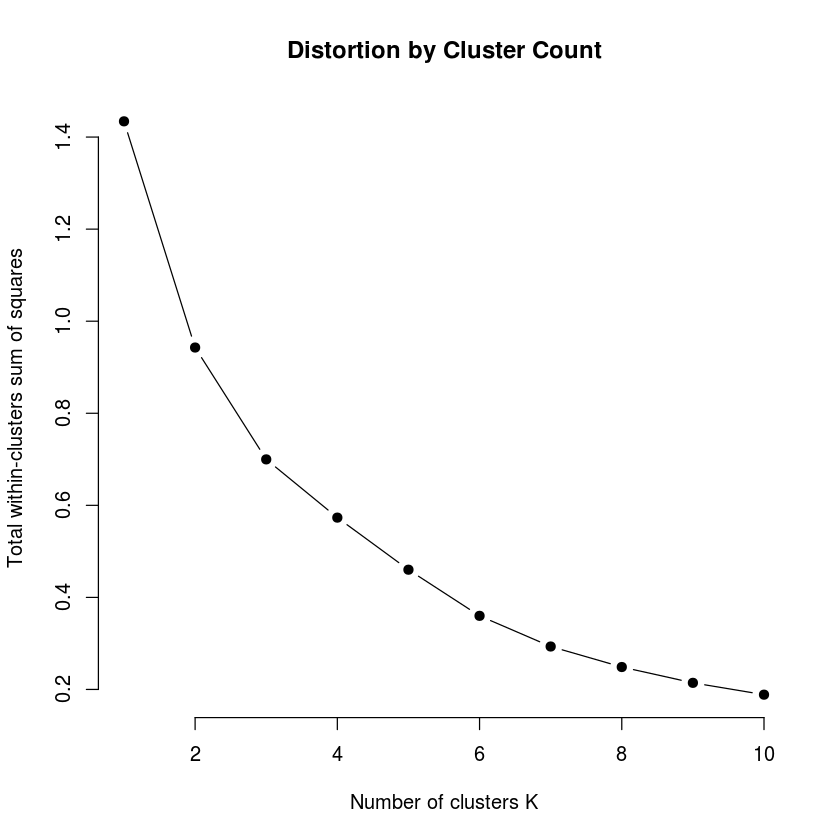

In [275]:
tgt_all %>%
select(
    ri_gourm_flag1,ri_hrs_low1,ri_prem_flag1,ri_price_low1
) -> tgt_all_clusters

set.seed(123)
k.max <- 10
data <- tgt_all_clusters
wss <- sapply(1:k.max, 
              function(k){kmeans(data, k, nstart=50,iter.max = 15 )$tot.withinss})

plot(1:k.max, wss,
     type="b", pch = 19, frame = FALSE, 
     xlab="Number of clusters K",
     ylab="Total within-clusters sum of squares",
    main="Distortion by Cluster Count")

In [253]:
tgt_all_clusters %>%
kmeans(3,nstart = 50,iter.max = 15) -> kmm

## PCA

PCA lets us condense the number of features of our data into 2 dimensions, which can help us visually understand the variation in our data.  We will run PCA on the relaitve importances of the four product attributes in our survey and condense the variability into 2 dimensions.

In [259]:
tgt_all %>%
select(

    ri_gourm_flag1,ri_hrs_low1,ri_prem_flag1,ri_price_low1
) %>%
mutate(
    ri_gourm_flag1=log(ri_gourm_flag1),
    ri_hrs_low1=log(ri_hrs_low1),
    ri_prem_flag1=log(ri_prem_flag1),
    ri_price_low1=log(ri_price_low1)
    
) -> tgt_all_pca
 
set.seed(123)
tgt_all_pca %>%
prcomp(center = TRUE,scale. = TRUE) -> pca

pred <- predict(pca, newdata=tgt_all_pca)
pred <- as.data.frame(cbind(pred,kmm$cluster))
colnames(pred) <- c("PC1","PC2","PC3","PC4","ClusterNum")

## Perceptual Map

Now that we have run our PCA and our K-Means to compress the variability of our four product attributes into 2 dimensions and split our customers into three clusters based on this variability, we can create a vizualization known as a perceptual map.

A **Perceptual Map** allows us to superimpose observations and attributes together in a 2D coordinate space.  From our plot we see the following:

* Three clusters are present
* The green cluster places more importance on travel time
* The black cluster places more importance on price
* The red cluster places more importance on gourmet food and premium seating.

**Takeaways:**
We appear to have three distinct segments of clusters, each that is more affiliated with a certain product feature.  First, we could design our products to appeal to each segment by creating a faster train package for the segment that values shorter travel times.  Second, we could create an economically valuable, lower-priced train package that appeals to customers who are more price sensitive.  Third, we can create a third package which gives customer access to higher quality seating and food options.

Warning message:
“Removed 12 rows containing missing values (geom_point).”

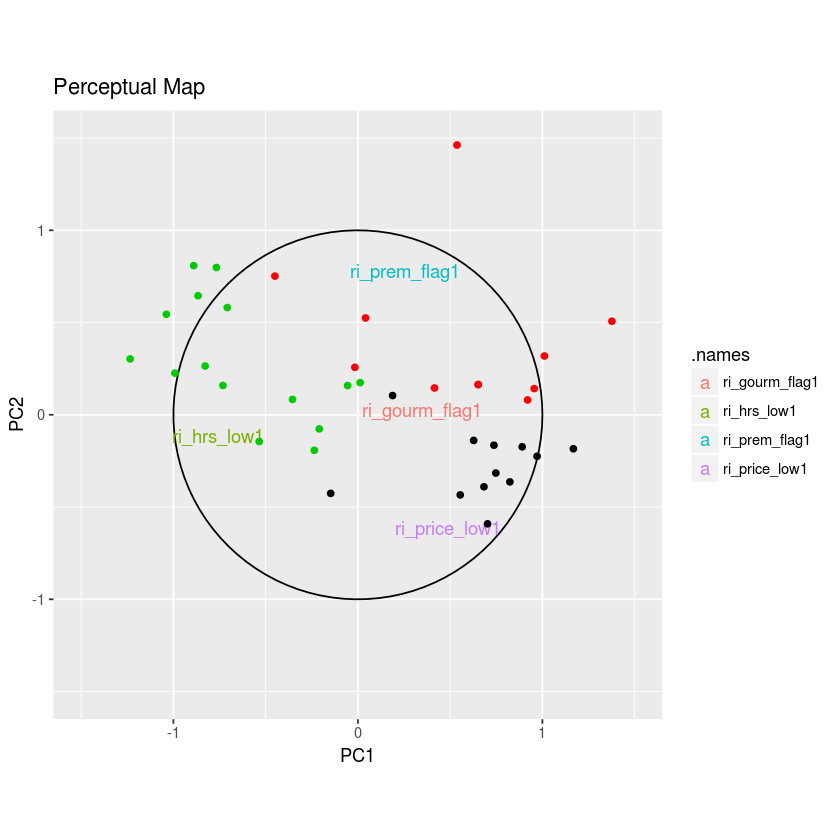

In [262]:
require(ggplot2)

theta <- seq(0,2*pi,length.out = 100)
circle <- data.frame(x = cos(theta), y = sin(theta))

p <- ggplot(circle,aes(x,y)) + geom_path()

loadings <- data.frame(pca$rotation, .names = row.names(pca$rotation))

p + geom_text(data=loadings, mapping=aes(x = PC1, y = PC2, label = .names, colour = .names)) +
    coord_fixed(ratio=1) + 
    labs(x = "PC1", y = "PC2") + 
    geom_point(data = pred, aes(x = PC1, y = PC2),color=pred$ClusterNum) +
    xlim(-1.5, 1.5) + 
    ylim(-1.5, 1.5) +
    ggtitle("Perceptual Map")

# Conclusion

In this analysis we have explored the concept of **Conjoint Analysis**.  Specifically, we have seen how this type of analysis can be used to extract the dollar values customers place on product features as well as segment a market based on the relative importances of product attributes.

Tools like conjoint analysis are crucial in helping market researchers make product design and pricing decisions.

I hope this analysis has made a meaningful contribution to your understanding of market research and related topics like regression, segmentation and unsupervised machine learning techniques.

Thanks for reading!
-Collier King